# Display Trace

## Packages

In [11]:
import os

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm.auto import tqdm

In [2]:
def scale(v, s=1):
    """Scale the vector of y \in R3,
    s is the  scaler,
    It computes the normalized vector of y is s = 1 as default.
    """
    return s * np.array(v) / np.linalg.norm(v)


def rotate(r, n, a):
    """Compute the rotated vector of r \in R3,
    n \in R3 is the rotate axis,
    a \in R is the radius.
    """
    d = np.cross(n, r)

    if all(d == 0):
        return r

    o = scale(scale(r, np.cos(a)) + scale(d, np.sin(a)))
    return o


class Point(object):
    """A point has its position and x-, y- and z- normalized coordinates"""

    def __init__(self, p=[0, 0, 0], nx=[1, 0, 0], ny=[0, 1, 0], nz=[0, 0, 1]):
        """
        Initialize the point,
        - p: The origin of the point;
        - nx: The normed x axis;
        - ny: The normed y axis;
        - nz: The normed z axis.
        """
        self.p = np.array(p).astype(np.float32)
        self.nx = scale(nx)
        self.ny = scale(ny)
        self.nz = scale(nz)
        pass

    def translate(self, dp):
        """Translate the point by p \in R3"""
        self.p += dp
        pass

    def rotate(self, ax, ay, az):
        """The point rotates around its origin, by 3 axis at ax, ay and az radius"""
        # self.nx = rotate(self.nx, self.nx, ax)
        self.ny = rotate(self.ny, self.nx, ax)
        self.nz = rotate(self.nz, self.nx, ax)

        self.nx = rotate(self.nx, self.ny, ay)
        # self.ny = rotate(self.ny, self.ny, ay)
        self.nz = rotate(self.nz, self.ny, ay)

        self.nx = rotate(self.nx, self.nz, az)
        self.ny = rotate(self.ny, self.nz, az)
        # self.nz = rotate(self.nz, self.nz, az)
        pass

    def snip(self):
        """Get a quick snip of the point on the current state"""
        # The p changes in-place, so use hard copy here.
        return [self.p.copy(), self.nx, self.ny, self.nz]


class MotionTrace(object):
    """Trace the motion and record every step"""

    def __init__(self):
        """Initialize"""
        # Dynamic point
        self.point = Point()

        # The point walks step-by-step,
        # the trace records its path.
        self.trace = []
        self.num_steps = 0

        # Reset the speed and angle
        self.dax = 0
        self.day = 0
        self.daz = 0
        self.dp = np.array((0.0, 0, 0))

        # Place the first point
        self.forward()
        pass

    def forward(self, ap=(0, 0, 0), aax=0, aay=0, aaz=0):
        """
        Forward a step,
        - ap: The accelerate of translating the position;
        - aax, aay, aaz: The angular accelerate of rotation along the x-, y- and z- axis.
        """

        def rad(x):
            return x / 180 * np.pi

        self.dax += aax
        self.day += aay
        self.daz += aaz
        self.dp += ap

        self.point.translate(self.dp)
        self.point.rotate(rad(self.dax), rad(self.day), rad(self.daz))
        self.trace.append(self.point.snip())

        self.num_steps += 1
        pass

    def trace_origin(self):
        """
        Trace the origins along the motion,
        it will return a matrix \in R^{n x 3},
        - n refers the steps, it equals to the self.num_samples;
        - 3 refers the x-, y- and z- coordinates.
        """
        return np.array([e[0] for e in self.trace])

    def trace_finish(self, length=500):
        """
        Trace the finish along the motion,
        the input
        - length refers the length of the arm/leg.
        the length grows at the negative direction of the z-axis.
        
        It will return a matrix \in R^{n x 3},
        - n refers the steps, it equals to the self.num_samples;
        - 3 refers the x-, y- and z- coordinates;
        """
        return np.array([e[0] - e[3] * length for e in self.trace])

## Read Parameters

In [3]:
folder = os.path.join(
    os.environ["SYNC"], r"MotionData\data\2nd-Development", "parsedData"
)

event_name = {
    "0-SLW": 1,
    "1-MLW": 2,
    "2-FLW": 3,
    "3-RD": 4,
    "4-SD": 5,
    "5-sit": 6,
    "6-stand": 7,
    "7-RA": 8,
    "8-SA": 9,
}

event_table = [(a, b) for a, b in event_name.items()]
print(event_table)

# Read and mark the Signal
X3s = []
ys = []

for name, label in event_name.items():
    with open(os.path.join(folder, f"{name}.npy"), "rb") as f:
        mat = np.load(f)
    X3s.append(mat)
    ys.append(np.zeros(mat.shape[0]) + label)

X3 = np.concatenate(X3s)
y = np.concatenate(ys)

# Simple Report
X3.shape, y.shape

[('0-SLW', 1), ('1-MLW', 2), ('2-FLW', 3), ('3-RD', 4), ('4-SD', 5), ('5-sit', 6), ('6-stand', 7), ('7-RA', 8), ('8-SA', 9)]


((31625, 20, 6), (31625,))

## Generate Cloud

In [5]:
if os.path.isfile(os.path.join(folder, "positions.npy")):
    with open(os.path.join(folder, "positions.npy"), "rb") as f:
        y = np.load(f)
        origins = np.load(f)
        finishs = np.load(f)
else:
    origins = []
    finishs = []

    for X in tqdm(X3):
        mt = MotionTrace()

        for d in X:
            mt.forward(ap=d[3:], aax=d[0], aay=d[1], aaz=d[2])
        origins.append(mt.trace_origin()[np.newaxis, :])
        finishs.append(mt.trace_finish()[np.newaxis, :])

    origins = np.array(origins)
    finishs = np.array(finishs)

    with open(os.path.join(folder, "positions.npy"), "wb") as f:
        np.save(f, y)
        np.save(f, origins)
        np.save(f, finishs)

origins.shape, finishs.shape

((31625, 1, 21, 3), (31625, 1, 21, 3))

In [6]:
origins = origins.squeeze()
finishs = finishs.squeeze()
[print(e.shape) for e in [origins, finishs, y]]

(31625, 21, 3)
(31625, 21, 3)
(31625,)


[None, None, None]

In [15]:
df = pd.DataFrame(finishs[:, -1], columns=["x", "y", "z"])
df["size"] = 0.5
df["label"] = [str(e) for e in y]
df

,x,y,z,size,label
0,4821.147952,22905.265803,5486.418333,0.5,1.0
1,152.833706,-15866.587791,1795.480963,0.5,1.0
2,-15522.913328,-28198.371330,-1300.279060,0.5,1.0
3,4477.809514,-4755.543329,3233.442957,0.5,1.0
4,9465.818008,44795.045120,-770.692667,0.5,1.0
...,...,...,...,...,...
31620,3102.749340,-13800.571742,69.533350,0.5,9.0
31621,-3352.319200,-26681.752824,-8323.431750,0.5,9.0
31622,-2789.776902,6655.642951,-481.317272,0.5,9.0
31623,7465.522555,3503.972148,-721.958696,0.5,9.0


In [16]:
def mk_clf():
    clf = Pipeline([("scaler", StandardScaler()), ("svc", SVC(gamma="auto"))])
    return clf


skf = StratifiedKFold(n_splits=10)
X = df[["x", "y", "z"]].values
p = y * 0

for train, test in tqdm(skf.split(y, y)):
    clf = mk_clf()
    clf.fit(X[train], y[train])
    p[test] = clf.predict(X[test])

print(metrics.classification_report(y_true=y, y_pred=p))

select = test
select.shape, X.shape

0it [00:00, ?it/s]

              precision    recall  f1-score   support

         1.0       0.30      0.58      0.40      3106
         2.0       0.34      0.39      0.36      2979
         3.0       0.55      0.30      0.39      3325
         4.0       0.32      0.22      0.26      3140
         5.0       0.41      0.43      0.42      4291
         6.0       0.58      0.21      0.30      3646
         7.0       0.51      0.89      0.65      3850
         8.0       0.41      0.07      0.13      2899
         9.0       0.46      0.56      0.51      4389

    accuracy                           0.42     31625
   macro avg       0.43      0.41      0.38     31625
weighted avg       0.44      0.42      0.39     31625



((3162,), (31625, 3))

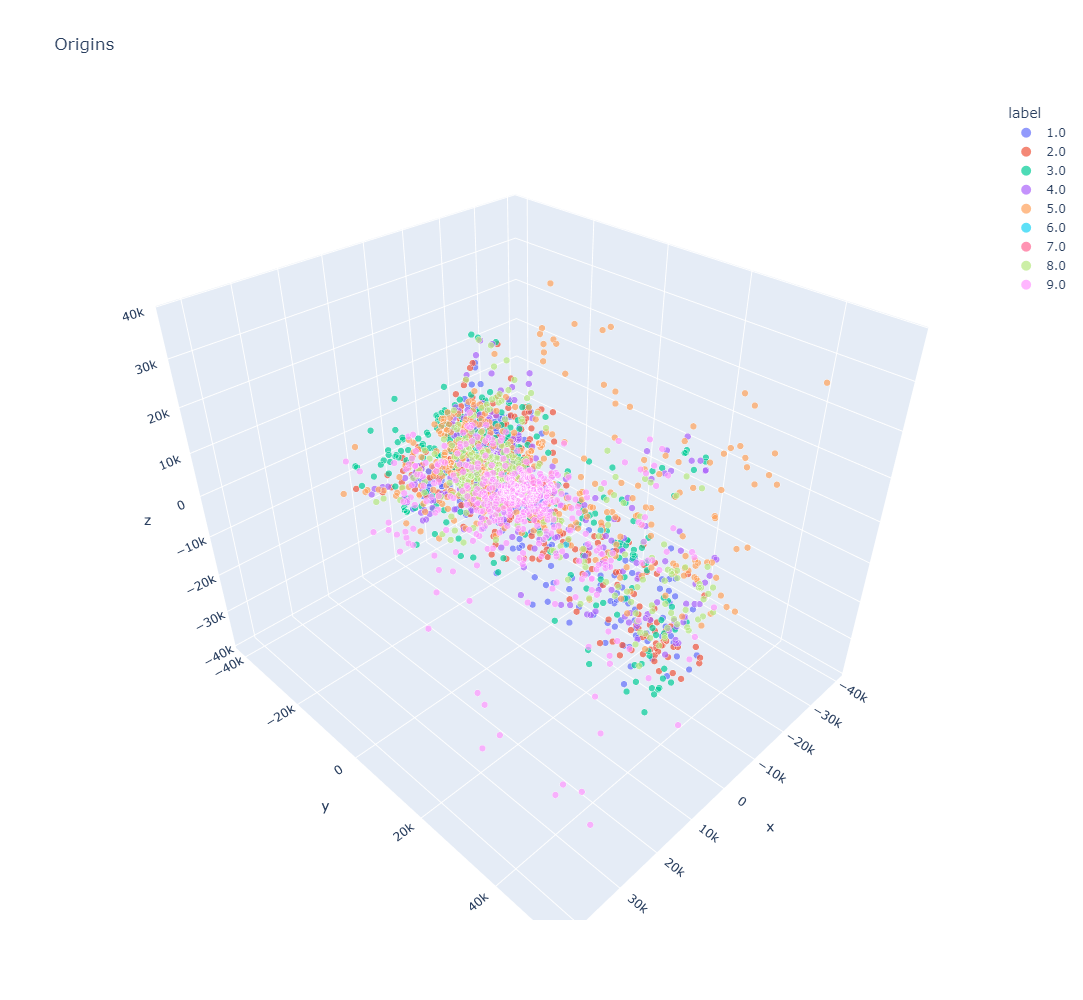

In [10]:
title = "Origins"

fig = px.scatter_3d(
    df.iloc[select],
    x="x",
    y="y",
    z="z",
    color="label",
    size="size",
    size_max=10,
    height=1000,
    width=1000,
    title=title,
)
fig.show()